## LASSO select features

In [1]:
## LASSO
from sklearn.linear_model import LassoCV#导入Lasso工具包LassoCV
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def Lasso_pack(lassox,lassoy,alpha_range,WARNING =False,lineup1 = 0.08, lineup2 = 0.01, dpi = 200):
    if WARNING == False:
        import warnings
        warnings.filterwarnings("ignore")
    #【LASSO】
    #3.3Lasso 特征筛选【C】
    #Lasso回归是最小二乘法回归的基础上加上L1正则表达式，L1正则表达式可以防止模型过拟合。
    #这里的用途是把不重要的特征变为0，进行特征筛选(降维，从一堆特征中，挑出一些有用的特征做分类任务)
    lassox_scd_df = lassox
    columnNames = lassox.columns
    # alpha_range = np.logspace(-3,1,100)
    #alpha_range在这个参数范围里挑出aplpha进行训练，cv是把数据集分5分，进行交叉验证，max_iter是训练1000轮
    lassoCV_model = LassoCV(alphas=alpha_range,cv=5,max_iter=1000)
    #进行训练
    lassoCV_model.fit(lassox_scd_df,lassoy)
    #打印lasso的截距
    print('lassoCV_model.intercept（Lasso截距）: ',lassoCV_model.intercept_)
    #打印训练找出来的lambda值
    print('lasso lambda:  ' + str(lassoCV_model.alpha_))
    coef = pd.Series(lassoCV_model.coef_, index=columnNames)
    print('Lasso筛选后特征数量变化：' + str(lassox.shape[1]) + ' → ' + str(sum(coef !=0)))
    print(coef[coef !=0])
    columns_index_C = coef[coef !=0].index.tolist()
    columns_index_c = columns_index_C#备份一个不带label的特征集，其内部特征为lasso筛选后的结果
   
    Coefficients_and_features = coef[coef !=0]
    Coefficients_and_features.to_frame()
    Coefficients_and_features = Coefficients_and_features.reset_index()
    Coefficients_and_features.columns = ['feature','Coefficients']
    display(Coefficients_and_features)

    #####################################################################
    #LASSO制图
    bbox_props = dict(boxstyle='round', facecolor='white', edgecolor='white')#设置白色背景
    #统计各aplha下coeff
    #coeffs矩阵转dataframe
    coefs = lassoCV_model.path(lassox_scd_df,lassoy, alphas=alpha_range, max_iter=1000)[1].T
    lasso_feature_nums = []
    for i in range(len(alpha_range)):
        coeffs_df = pd.DataFrame(coefs).T
        coeffs_df2 = coeffs_df.copy(deep = True)
        correct_columns = coeffs_df.columns.tolist()
        correct_columns.reverse()
        coeffs_df2.columns = correct_columns
        coeffs_df3 = coeffs_df2.sort_index(axis = 1)
        un_zero_num = len(coeffs_df3[coeffs_df3.columns[i]].tolist()) - coeffs_df3[coeffs_df3.columns[i]].tolist().count(0)
        lasso_feature_nums.append(un_zero_num)
    
    #查找最佳特征数对应的alpha的索引，以及其对应的特征个数
    best_feature_num = lasso_feature_nums[len(lasso_feature_nums) - lassoCV_model.alphas_.tolist().index(lassoCV_model.alpha_)-1]
    n_show = 8#图表顶部显示几个刻度
    interval = (len(lasso_feature_nums) - 1) // n_show
    counts_result = lasso_feature_nums[::interval+1][:n_show + 1]
    alpha_result = alpha_range.tolist()[::interval+1][:n_show + 1]
    #【LASSO lambda-coef图】
    #3.7 Lasso lambda-coef图
    #这个图显示随着lambda 的变化，系数的变化走势（Lasso lambda-coef图）
    fig, ax1 = plt.subplots(dpi = dpi,facecolor='white')
    ax1.semilogx(lassoCV_model.alphas_, coefs)
    plt.axvline(lassoCV_model.alpha_, color='red', ls='--')
    ax1.set_xlim(alpha_range[0], alpha_range[-1])
    rect_width = ax1.get_xlim()[1] - alpha_range[0]
    rect_height = 0.025
    rect_x = alpha_range[0]
    rect_y = ax1.get_ylim()[1]
    rect = plt.Rectangle((rect_x, rect_y), rect_width, rect_height, facecolor='white', clip_on=False, linewidth=0)
    ax1.add_patch(rect)

    for i in range(len(counts_result)):
        ax1.text(
            alpha_result[i],
            ax1.get_ylim()[1] + lineup1, 
            counts_result[i],
            fontsize = 10,
            ha='center',
            zorder = 5,
            color = 'k')
    ax1.text(
        lassoCV_model.alpha_,
        ax1.get_ylim()[1] + lineup1,
        str(len(coef[coef !=0].tolist())),#str(best_feature_num),#r'$\mathregular{12}$',
        fontsize = 10,
        ha='center',
        zorder = 5,
        bbox=bbox_props,
        color = 'k')
    print(ax1.get_ylim()[1])
    plt.xlabel('Lambda')
    plt.ylabel('coefficients')
    plt.show()
    plt.close()

    #【LASSO误差棒图】
    #3.6绘制误差棒图
    MSEs = lassoCV_model.mse_path_
    MSEs_mean = np.apply_along_axis(np.mean,1,MSEs)
    MSEs_std = np.apply_along_axis(np.std,1,MSEs)
    fig, ax1 = plt.subplots(dpi = dpi,facecolor='white')

    ax1.errorbar(lassoCV_model.alphas_,MSEs_mean,yerr=MSEs_std,fmt='o:',ms = 3,mfc='r',mec = 'r',ecolor='lightblue',elinewidth = 2,capthick = 1,capsize=3)
    ax1.semilogx()
    ax1.axvline(lassoCV_model.alpha_, color='black', ls='--')

    ax1.set_xlim(alpha_range[0], alpha_range[-1])
    rect_width = ax1.get_xlim()[1] - alpha_range[0]
    rect_height = (ax1.get_ylim()[1] - ax1.get_ylim()[0])/8
    rect_x = alpha_range[0]
    rect_y = ax1.get_ylim()[1]
    rect = plt.Rectangle((rect_x, rect_y), rect_width, rect_height, facecolor='white', clip_on=False, linewidth=0)
    ax1.add_patch(rect)

    for i in range(len(counts_result)):
        ax1.text(
            alpha_result[i],
            ax1.get_ylim()[1] + lineup2, 
            counts_result[i],
            fontsize = 10,
            ha='center',
            zorder = 5,
            color = 'k')
    ax1.text(
        lassoCV_model.alpha_,
        ax1.get_ylim()[1] + lineup2, 
        str(len(coef[coef !=0].tolist())),#str(best_feature_num),#r'$\mathregular{12}$',
        fontsize = 10,
        ha='center',
        zorder = 5,
        bbox=bbox_props,
        color = 'k')

    #ax1.set_title('Errorbar\n')
    plt.xlabel('Lambda')
    plt.ylabel('MSE')
    plt.show()

    plt.close()
    return(Coefficients_and_features,lassoCV_model.intercept_,lassoCV_model)


## LASSO

Lasso-selected features:
ast: 0.18832320905457414
nihss: 0.166472083317537
pt: 0.10809717099454698
hypertension: 0.10685542781263972
wbc: 0.09490365278923998
rbc: 0.08945784877738028
d_dimer: 0.07416585811272976
hba1c: 0.0677693915246363
ck: 0.05763716112360908
ldl: 0.05400872826431723
tg: 0.038199687895841904
pca: 0.024014982006780795
ima: 0.02235157903158264
parietal_lobe: 0.0214983781594616
post_circle: 0.018713369202305378
subcortex_lobe: 0.018155636788409583
bilirubin: 0.01655958931351884
tco2: 0.013985224750297771
centrum_semiovale: 0.011249823877972204
hyperuricemia: 0.01039472960319073
frontal_lobe: 0.008114296747540604
uremia: 0.0067484723469874225
hydrocephalus: 0.006675848300295557
large_ves_as: 0.006604373488006826
eca_plaque: 0.0056426408555926835
epencephalon: 0.0018853989928112548
fatty_liver: 0.0014077380093611737
cca_plaque: 2.6742188630345087e-05
ast
nihss
pt
hypertension
wbc
rbc
d_dimer
hba1c
ck
ldl
tg
pca
ima
parietal_lobe
post_circle
subcortex_lobe
bilirubin
tco2
c

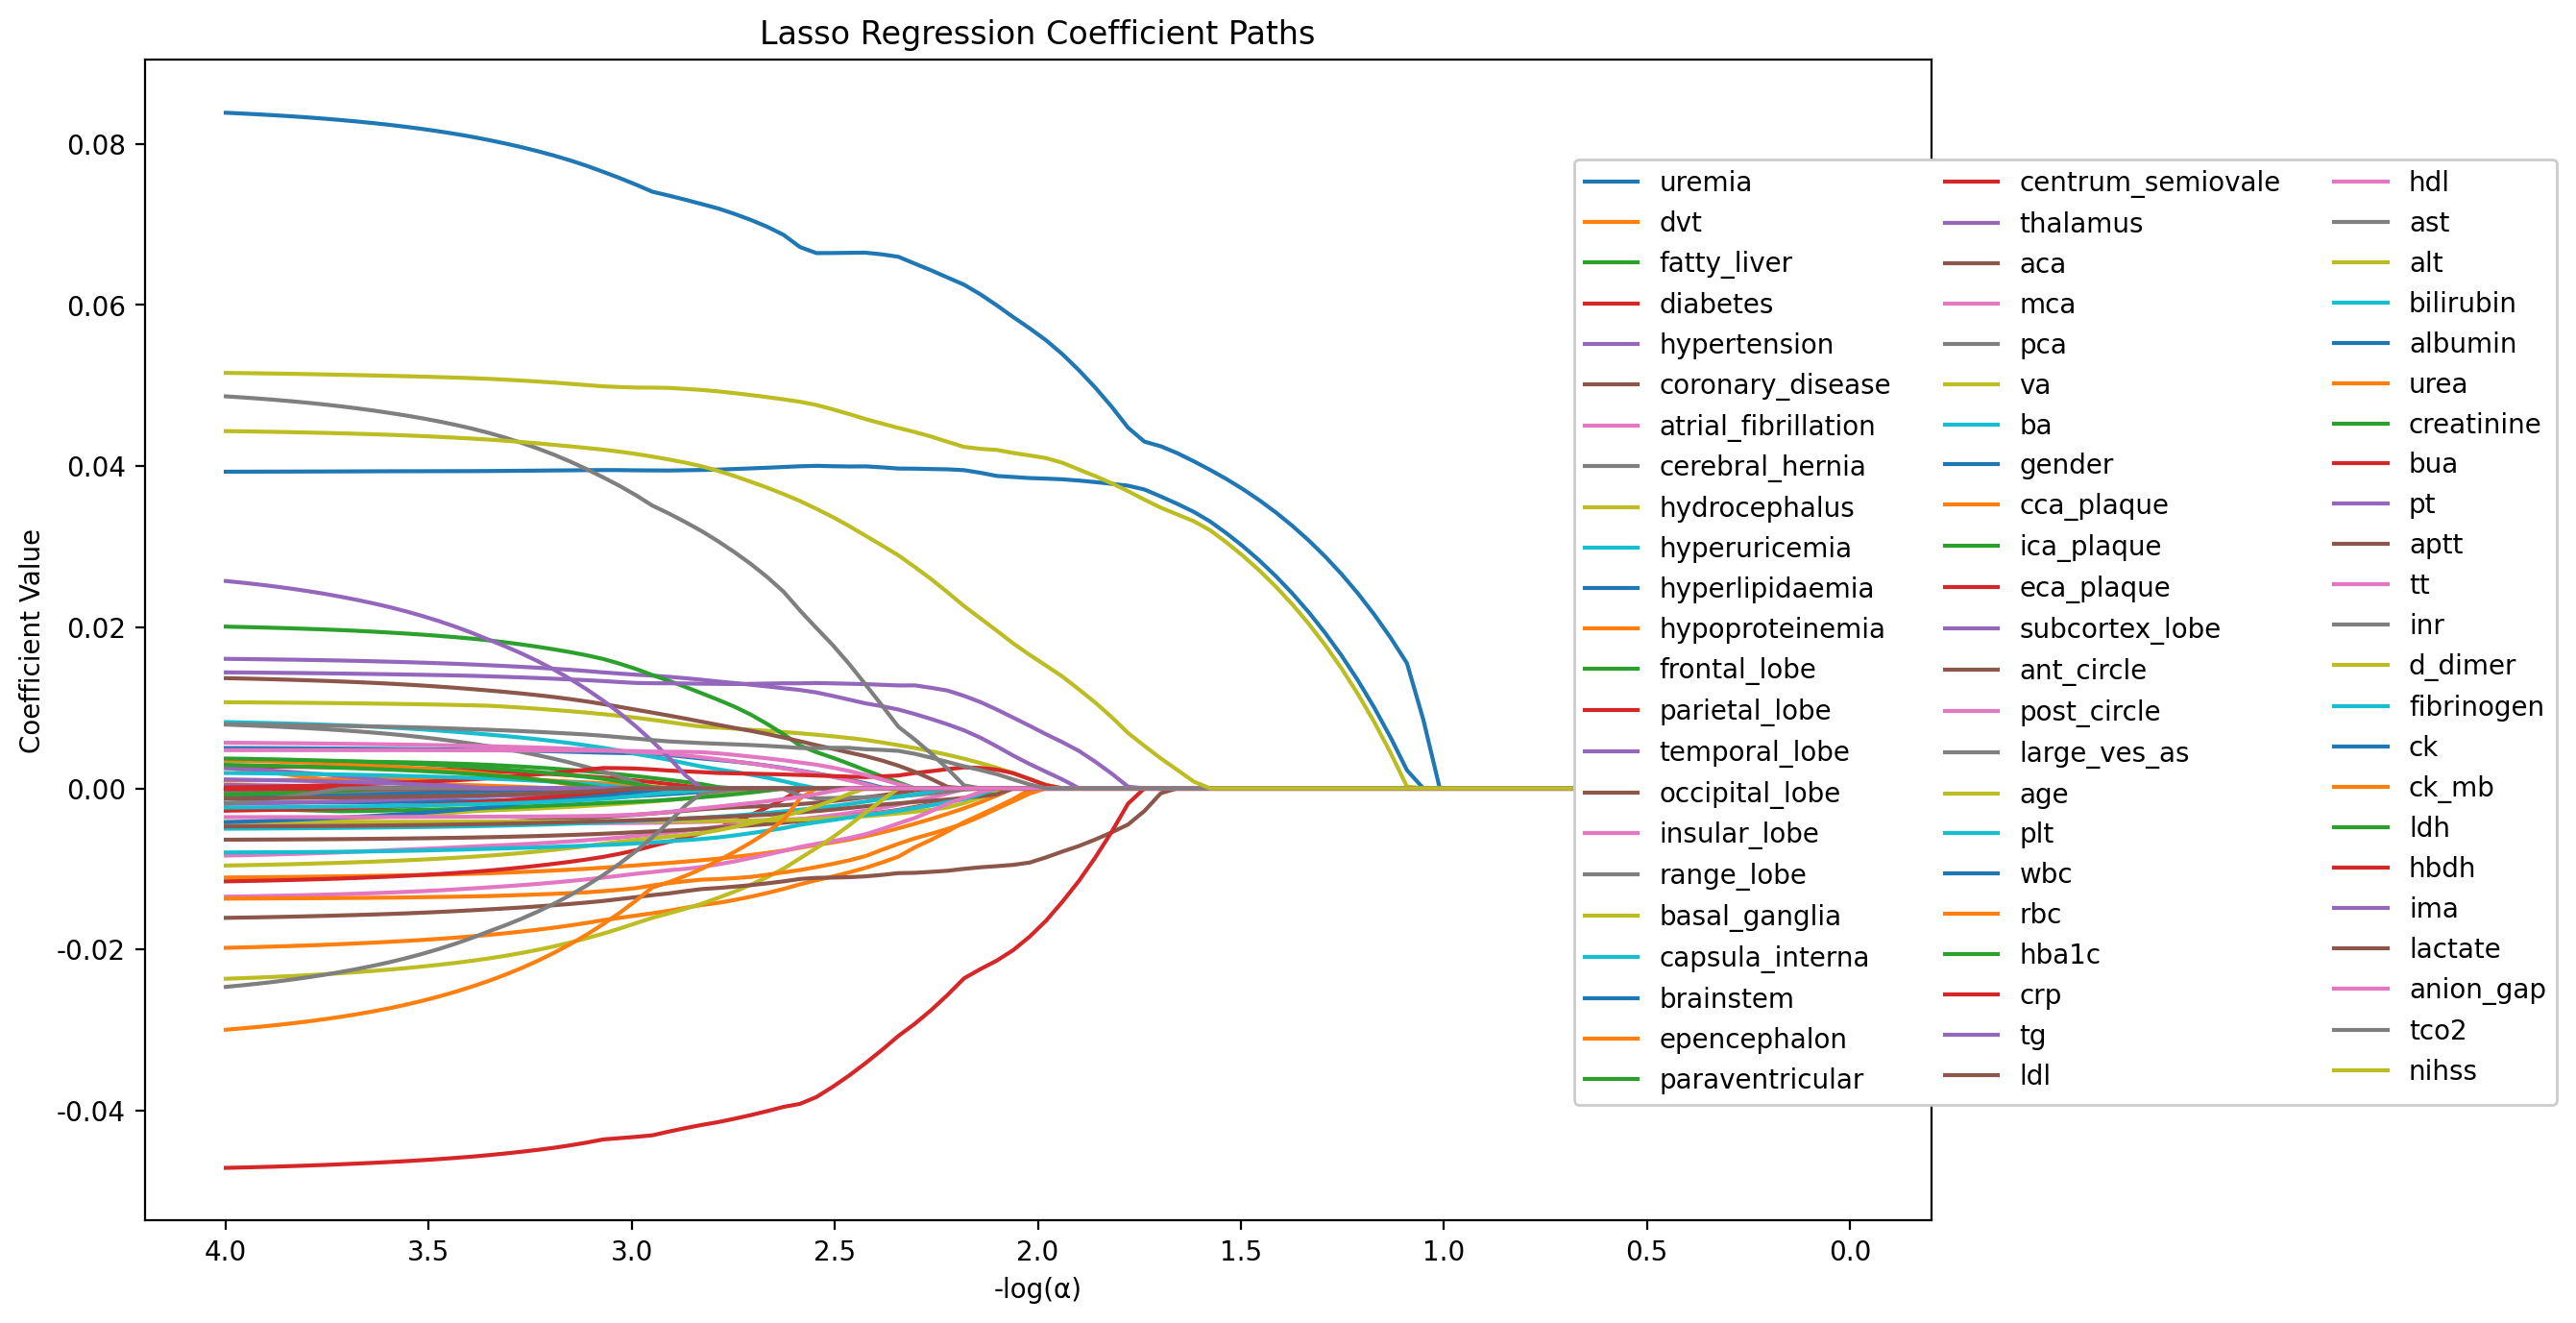

In [2]:
# LASSO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LassoCV, lasso_path

data = pd.read_csv(r'H:\data\data.csv')
X = data.drop(['second_epilepsy', "na","k","cl","ca","p"], axis=1)
y = data['second_epilepsy']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Use SMOTE to handle the imbalanced training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Perform Lasso regression and select the best features
lasso = LassoCV(cv=5)
lasso.fit(X_train_resampled, y_train_resampled)
selected_features = X.columns[lasso.coef_ > 0]
selected_coefficients = lasso.coef_[lasso.coef_ > 0]

# Get the sorted indices based on coefficient magnitude
sorted_indices = np.argsort(selected_coefficients)[::-1]

# Print the selected features and their coefficients
print("Lasso-selected features:")
for index in sorted_indices:
    feature = selected_features[index]
    coefficient = selected_coefficients[index]
    print(f"{feature}: {coefficient}")
for index in sorted_indices:
    feature = selected_features[index]
    print(f'{feature}')

# Plot the Lasso regression coefficient paths
alphas, coefs, _ = lasso_path(X_train, y_train, alphas=np.logspace(-4, 0, 100))
plt.figure(figsize=(12, 8),dpi = 200,facecolor = 'white')
neg_log_alphas = -np.log10(alphas)
for i, feature in enumerate(X.columns):
    plt.plot(neg_log_alphas, coefs[i], label=feature)
plt.xlabel('-log(α)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Regression Coefficient Paths')
plt.legend(ncol=3,loc = (0.8,0.1),framealpha = 1)
# plt.grid(True)
plt.grid(False)
plt.gca().invert_xaxis()
plt.show()


# alpha_range = np.logspace(-6,1,100)
# lasso_result,lasso_intercept,lassoCV_model = Lasso_pack(X_train_resampled, y_train_resampled,alpha_range, dpi = 150)

# lasso_result_sorted = lasso_result.sort_values(by='Coefficients', key=lambda x: abs(x), ascending=False)
# print(lasso_result_sorted)

## MODEL

In [2]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np
import os
import joblib
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.combine import SMOTEENN

data = pd.read_csv(r'H:\data\data.csv')

# Split the data into features and target variable
X = data.drop(['second_epilepsy', "na", "k", "cl", "ca", "p"], axis=1)  # 'pneumonia'  #,'na','nihss','tco2' # 'sequelae', 'psychology_disorder',
var = 'second_epilepsy'
y = data[var]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.7, random_state=42)

smoteenn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.01)  # 设置alpha参数来控制正则化程度
lasso.fit(X_train_resampled, y_train_resampled)
feature_importances = np.abs(lasso.coef_)  # 获取特征的重要性得分（系数的绝对值）
k = 20
top_k_features_indices = np.argsort(feature_importances)[-k:]  # 获取重要性得分最高的K个特征的索引
selected_features = X_train.columns[top_k_features_indices]  # 获取选定的特征列名

X_train_resampled = X_train_resampled[selected_features]
X_train = X_train[selected_features]  # 仅保留选定的特征列
X_test = X_test[selected_features]  # 在测试集上也进行相同的特征选择

# Initialize the classifiers
classifiers = {
    'LR': LogisticRegression(max_iter=5000),  # Logistic Regression
    'NB': GaussianNB(),  # Naive Bayes
    'DT': DecisionTreeClassifier(),  # Decision Tree Classifier
    'GB': GradientBoostingClassifier(),  # GradientBoosting
    'RF': RandomForestClassifier(),  # Random Forest Classifier
    'MLP': MLPClassifier(),  # MLP
    'XGB': XGBClassifier(),  # XGBoost
    'LGBM': LGBMClassifier(),  # LightGBM
    'KNN': KNeighborsClassifier(),  # KNeighbors
}

# Define parameter grids for GridSearchCV
param_grids = {
    'LR': {'C': [0.01, 0.1, 1, 10, 100]},
    'NB': {},
    'DT': {'max_depth': [3, 5, 10, None]},
    'GB': {'learning_rate': [0.01, 0.1, 0.2], 'n_estimators': [100, 200]},
    'RF': {'n_estimators': [100, 200], 'max_features': ['auto', 'sqrt', 'log2']},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]},
    'XGB': {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]},
    'LGBM': {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200]},
    'KNN': {'n_neighbors': [5, 10, 15]}
}

YYPs = []  # 用来保存训练集各模型的预测结果（概率）
yyPs = []  # 用来保存测试集各模型的预测结果（概率）
YYDs = []  # 用来保存训练集各模型的预测结果
yyDs = []  # 用来保存测试集各模型的预测结果
curve_names = []  # 用来保存模型名称
best_models = []  # 用来保存拟合好的模型

# Train and evaluate each classifier with feature selection and hyperparameter optimization
plt.figure(figsize=(10, 6))
for name, classifier in classifiers.items():
    curve_names.append(name)
    print('Model training: ', name)
    save_path = '.\\model\\{}\\'.format(var)
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    grid_search = GridSearchCV(classifier, param_grids[name], cv=5, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_classifier = grid_search.best_estimator_

    if name in ['LR', 'RF', 'LGBM', 'XGB', 'NB']:
        model_file = os.path.join(save_path, f'{name}_model.pkl')
        joblib.dump(best_classifier, model_file)

    Y_pred_proba = best_classifier.predict_proba(X_train)[:, 1]
    y_pred_proba = best_classifier.predict_proba(X_test)[:, 1]
    YYPs.append(Y_pred_proba)
    yyPs.append(y_pred_proba)

    best_models.append(best_classifier)

    Y_pred = best_classifier.predict(X_train)
    y_pred = best_classifier.predict(X_test)
    YYDs.append(Y_pred)
    yyDs.append(y_pred)



Model training:  LR
Model training:  NB
Model training:  DT
Model training:  GB
Model training:  RF
Model training:  MLP
Model training:  XGB
Model training:  LGBM
[LightGBM] [Info] Number of positive: 10257, number of negative: 9863
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4115
[LightGBM] [Info] Number of data points in the train set: 20120, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509791 -> initscore=0.039170
[LightGBM] [Info] Start training from score 0.039170
Model training:  KNN


<Figure size 1000x600 with 0 Axes>

In [3]:
final_model = 'RF'

## ROC

AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢
AUCCI =True，正在计算AUC置信区间，出图可能较慢


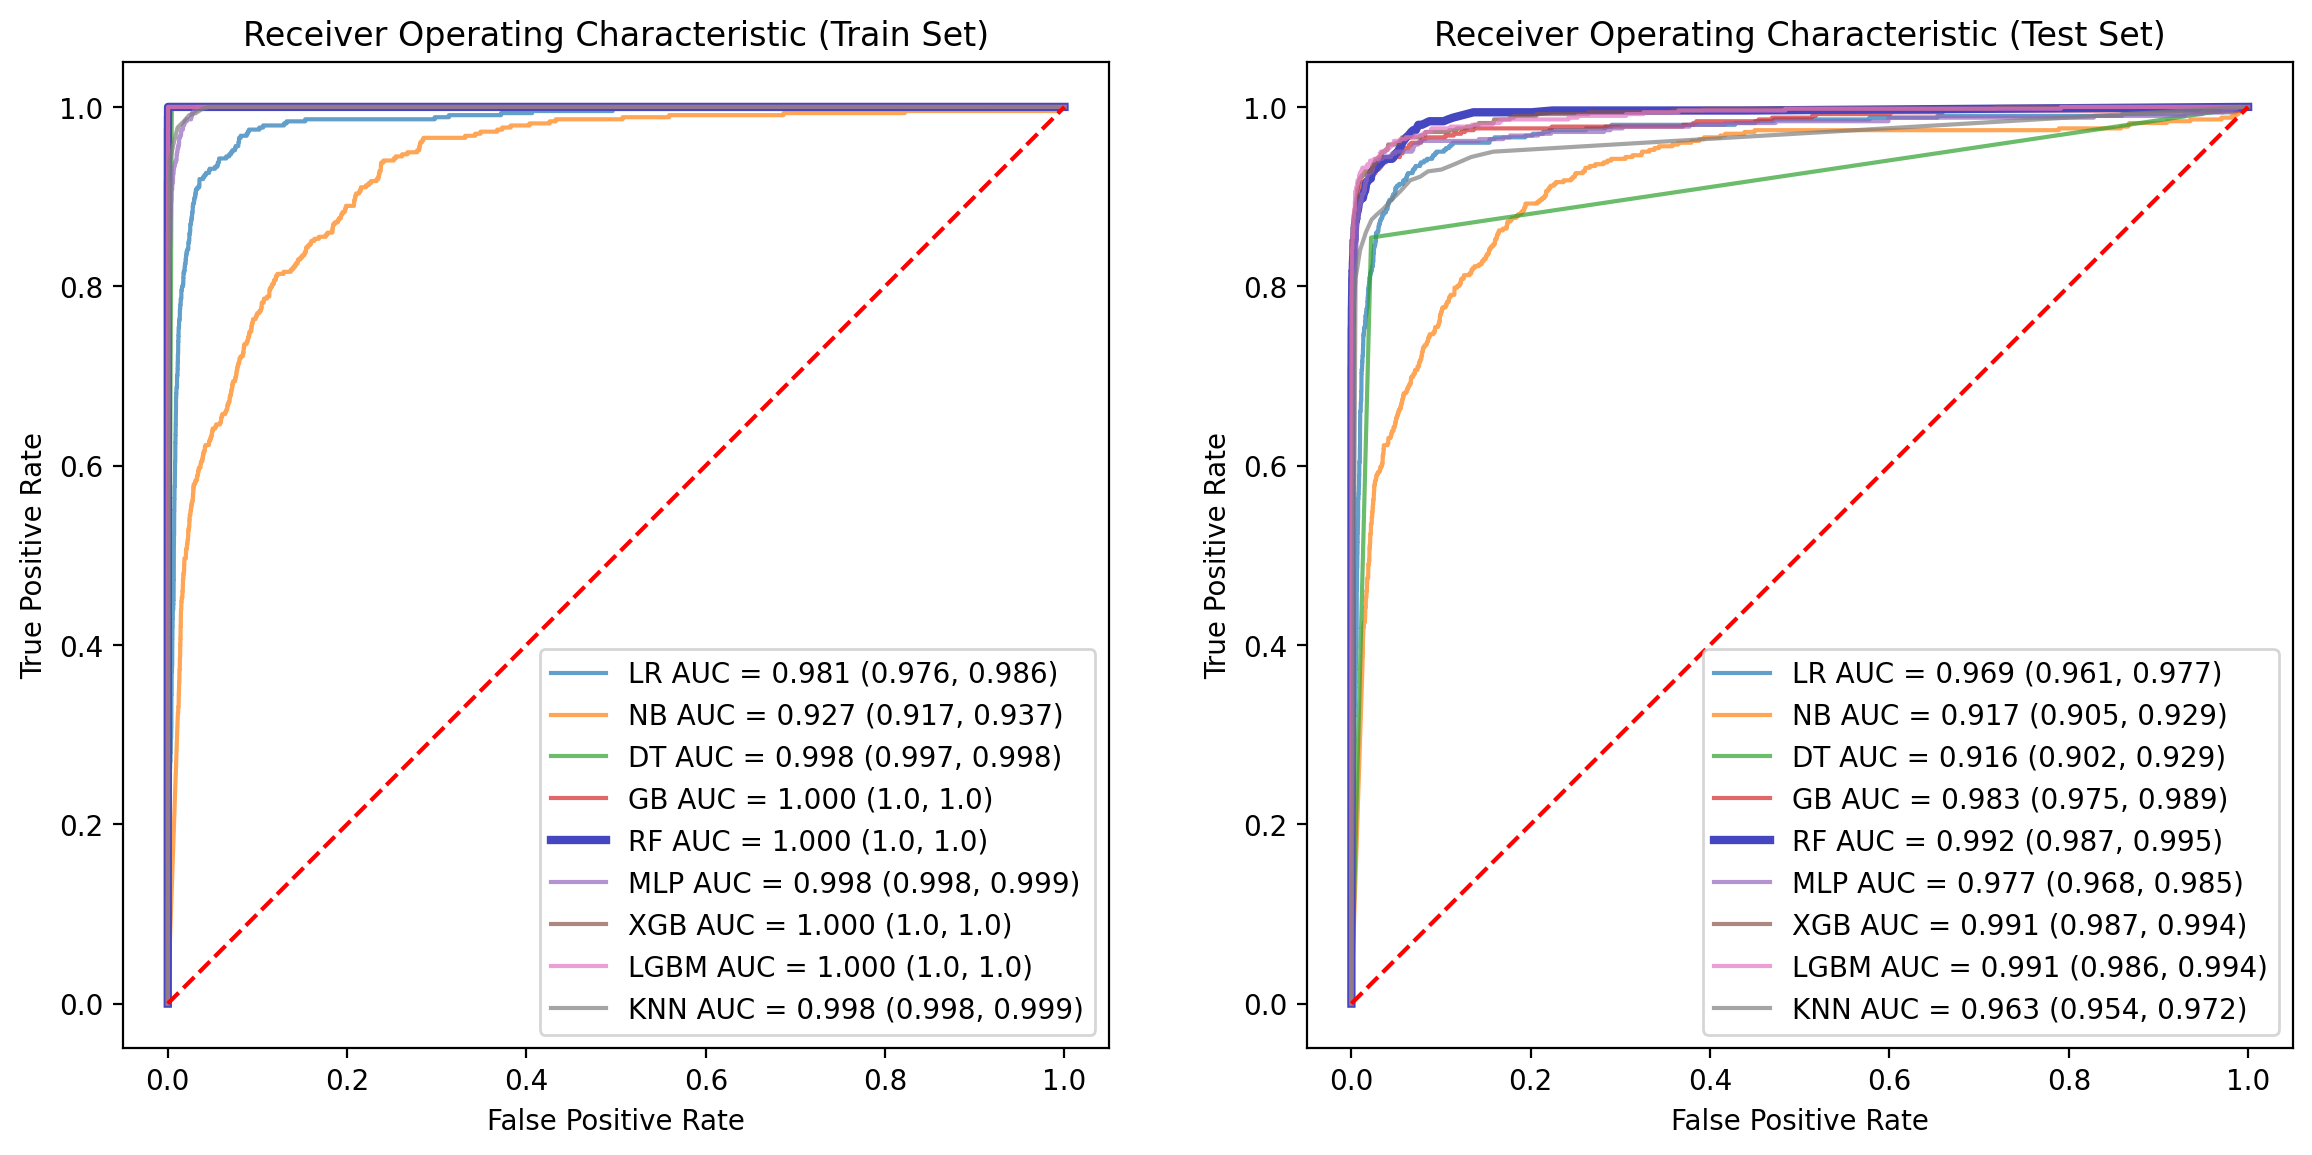

In [4]:
# 一些必须函数
random_state = 2024

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, auc
pic_path = '.\\'
def AUC_95CI(yy,yyP,random_state):
    #https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist
    y_pred = np.array(yyP)#np.array(yyP.tolist())
    y_true = np.array(yy)#np.array(yy.tolist())
    n_bootstraps = 1000
    rng_seed = random_state
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        # 通过对预测指数进行替换抽样，进行引导分析
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            # 我们需要至少一个阳性样本和一个阴性样本来确定ROC AUC
            # 的定义：拒绝样本
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
        #print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()

    # Computing the lower and upper bound of the 90% confidence interval
    # You can change the bounds percentiles to 0.025 and 0.975 to get
    # a 95% confidence interval instead.
    confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
    #print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(confidence_lower, confidence_upper))
    return(round(confidence_lower,3),round(confidence_upper,3))
def plotAUCs(YY,yy,YY_probs,yy_probs,curve_names,save_name,final_model = final_model,AUCCI = False ,random_state = random_state,pic_path = pic_path, ):
    # 创建一个包含两个子图的画布
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7),dpi = 200,facecolor='white')
    # 设置子图纵横比为1，使其成为正方形
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')

    for i in range(len(curve_names)):
        # 计算训练集和测试集的FPR、TPR和阈值
        fpr_train, tpr_train, thresholds_train = roc_curve(YY, YY_probs[i])
        fpr_test, tpr_test, thresholds_test = roc_curve(yy, yy_probs[i])
        
        # 计算置信区间
        if AUCCI ==True:
            print('AUCCI =True，正在计算AUC置信区间，出图可能较慢')
            train_aucci = AUC_95CI(YY,YY_probs[i],random_state)
            test_aucci = AUC_95CI(yy,yy_probs[i],random_state)
        else:
            train_aucci = ''#AUC_95CI(YY,YY_probs[i],random_state)
            test_aucci = ''#AUC_95CI(yy,yy_probs[i],random_state)
        # print(train_aucci,test_aucci)
        emphasis_color = (68/255,71/255,191/255)
        # 计算训练集和测试集的AUC
        auc_train = roc_auc_score(YY, YY_probs[i])# auc(fpr_train, tpr_train)
        auc_test = roc_auc_score(yy, yy_probs[i])# auc(fpr_test, tpr_test)
        if curve_names[i] != final_model:
            ax1.plot(fpr_train, tpr_train, label=curve_names[i] + ' AUC = %0.3f' % auc_train + " " + str(train_aucci),alpha = 0.7)
            ax2.plot(fpr_test, tpr_test, label=curve_names[i] + ' AUC = %0.3f' % auc_test + " " + str(test_aucci),alpha = 0.7)
        if curve_names[i] == final_model:
            ax1.plot(fpr_train, tpr_train, label=curve_names[i] + ' AUC = %0.3f' % auc_train + " " + str(train_aucci),lw = 3,color = emphasis_color)
            ax2.plot(fpr_test, tpr_test, label=curve_names[i] + ' AUC = %0.3f' % auc_test + " " + str(test_aucci),lw = 3,color = emphasis_color)

    # 绘制训练集的AUC曲线

    ax1.plot([0, 1], [0, 1], 'r--')
    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver Operating Characteristic (Train Set)')
    ax1.legend(loc="lower right")

    # 绘制测试集的AUC曲线

    ax2.plot([0, 1], [0, 1], 'r--')
    ax2.set_xlim([-0.05, 1.05])
    ax2.set_ylim([-0.05, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (Test Set)')
    ax2.legend(loc="lower right")

    # 显示图形
    # plt.savefig(pic_path + "\\" + save_name + ".png" )
    plt.show()

# ROC
plotAUCs(y_train,y_test,YYPs,yyPs,curve_names,save_name = "aucs",final_model = final_model,AUCCI = True)

## Model evaluation

In [5]:
# Model evaluation function
def BEST_thresholdYouden(YY_pred_ori, YY_true):
    # Calculate TPR and FPR at different classification thresholds on the test set
    fpr, tpr, thresholds = roc_curve(y_true=YY_true, y_score=YY_pred_ori)

    # Determine the optimal classification threshold based on the maximum Youden index
    youden_scores = tpr - fpr
    best_index = np.argmax(youden_scores)
    best_threshold = thresholds[best_index]
    # print("Best classification threshold: {:.3f}".format(best_threshold))
    return best_threshold

def convert_list(lst, f):
    return [1 if num > f else 0 for num in lst]

def Model_Evaluation2(y_true, y_prob, y_pred, Mode='Train', threshold_input=0.5):
    if Mode == "Train":
        threshold = BEST_thresholdYouden(y_prob, y_true)
        print('Train mode, threshold = ', threshold)
    if Mode == "Test":
        threshold = threshold_input
        # print('Test mode, threshold = ', threshold)

    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_score
    y_true = np.array(y_true)
    # y_pred = convert_list(y_prob, threshold)
    # y_pred = np.array(y_pred)
    
    test_auc = roc_auc_score(y_true, y_prob)
    test_acc = accuracy_score(y_true, y_pred)
    # report = classification_report(y_true, y_pred, output_dict=True)
    # test_f1 = report['1']['f1-score']
    # test_recall = report['1']['recall']
    # test_tp = np.sum((y_true == 1) & (y_pred == 1))
    # test_fp = np.sum((y_true == 0) & (y_pred == 1))
    # test_tn = np.sum((y_true == 0) & (y_pred == 0))
    # test_fn = np.sum((y_true == 1) & (y_pred == 0))
    
    cm = confusion_matrix(y_true, y_pred)
    test_tn, test_fp, test_fn, test_tp = cm.ravel()
    
    test_sen = test_tp / (test_tp + test_fn)  # Sensitivity/Recall
    test_spe = test_tn / (test_tn + test_fp)  # Specificity
    test_ppv = test_tp / (test_tp + test_fp)  # Positive Predictive Value
    test_npv = test_tn / (test_tn + test_fn)  # Negative Predictive Value
    test_precision = test_ppv
    test_recall = test_sen
    test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)
    
    # test_precision = precision_score(y_true, y_pred)
    return [
        test_auc,
        test_acc,
        test_sen,
        test_spe,
        test_f1,
        test_ppv,
        test_npv,
        threshold
        # test_precision
    ]

In [7]:
# 综合评估
## 模型评估
Train_evaluations = pd.DataFrame(columns = ['Model','AUC','Accuracy','Sensitivity/Recall','Specificity','F1-score','PPV/precision','NPV','Cutoff'])
for i in range(len(YYPs)):
    Train_evaluations.loc[i] = [curve_names[i]] + Model_Evaluation2(y_train,YYPs[i],YYDs[i], Mode = 'Test')

Test_evaluations = pd.DataFrame(columns = ['Model','AUC','Accuracy','Sensitivity/Recall','Specificity','F1-score','PPV/precision','NPV','Cutoff'])
for i in range(len(yyPs)):
    Test_evaluations.loc[i] = [curve_names[i]] + Model_Evaluation2(y_test,yyPs[i],yyDs[i],Mode = 'Test')

# 选择除了第一列之外的列进行操作
df_A_values = Train_evaluations.iloc[:, 1:].applymap(lambda x: f"{x:.3f}")
df_B_values = Test_evaluations.iloc[:, 1:].applymap(lambda x: f"{x:.3f}")

# 合并格式化后的数值列，并保留第一列
Evaluations_combined_values = df_A_values + " | " + df_B_values
Evaluations_combined = pd.concat([Train_evaluations.iloc[:, [0]], Evaluations_combined_values], axis=1)
print("综合评估指标，训练集|测试集：")
Evaluations_combined



综合评估指标，训练集|测试集：


,Model,AUC,Accuracy,Sensitivity/Recall,Specificity,F1-score,PPV/precision,NPV,Cutoff
0,LR,0.981 | 0.969,0.950 | 0.946,0.931 | 0.912,0.950 | 0.948,0.600 | 0.613,0.442 | 0.462,0.997 | 0.995,0.500 | 0.500
1,NB,0.927 | 0.917,0.906 | 0.906,0.736 | 0.743,0.913 | 0.914,0.389 | 0.424,0.264 | 0.296,0.988 | 0.986,0.500 | 0.500
2,DT,0.998 | 0.916,0.996 | 0.972,1.000 | 0.854,0.996 | 0.978,0.950 | 0.742,0.904 | 0.655,1.000 | 0.993,0.500 | 0.500
3,GB,1.000 | 0.983,0.995 | 0.988,1.000 | 0.908,0.995 | 0.991,0.945 | 0.872,0.895 | 0.838,1.000 | 0.995,0.500 | 0.500
4,RF,1.000 | 0.992,0.997 | 0.990,1.000 | 0.870,0.997 | 0.996,0.970 | 0.887,0.942 | 0.905,1.000 | 0.994,0.500 | 0.500
5,MLP,0.998 | 0.977,0.988 | 0.984,0.947 | 0.902,0.990 | 0.987,0.867 | 0.836,0.800 | 0.779,0.998 | 0.995,0.500 | 0.500
6,XGB,1.000 | 0.991,0.997 | 0.990,1.000 | 0.908,0.997 | 0.994,0.966 | 0.892,0.933 | 0.877,1.000 | 0.995,0.500 | 0.500
7,LGBM,1.000 | 0.991,0.998 | 0.992,1.000 | 0.904,0.998 | 0.996,0.973 | 0.909,0.948 | 0.913,1.000 | 0.995,0.500 | 0.500
8,KNN,0.998 | 0.963,0.956 | 0.943,1.000 | 0.906,0.954 | 0.945,0.647 | 0.599,0.478 | 0.448,1.000 | 0.995,0.500 | 0.500


## Calibration curve

c:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


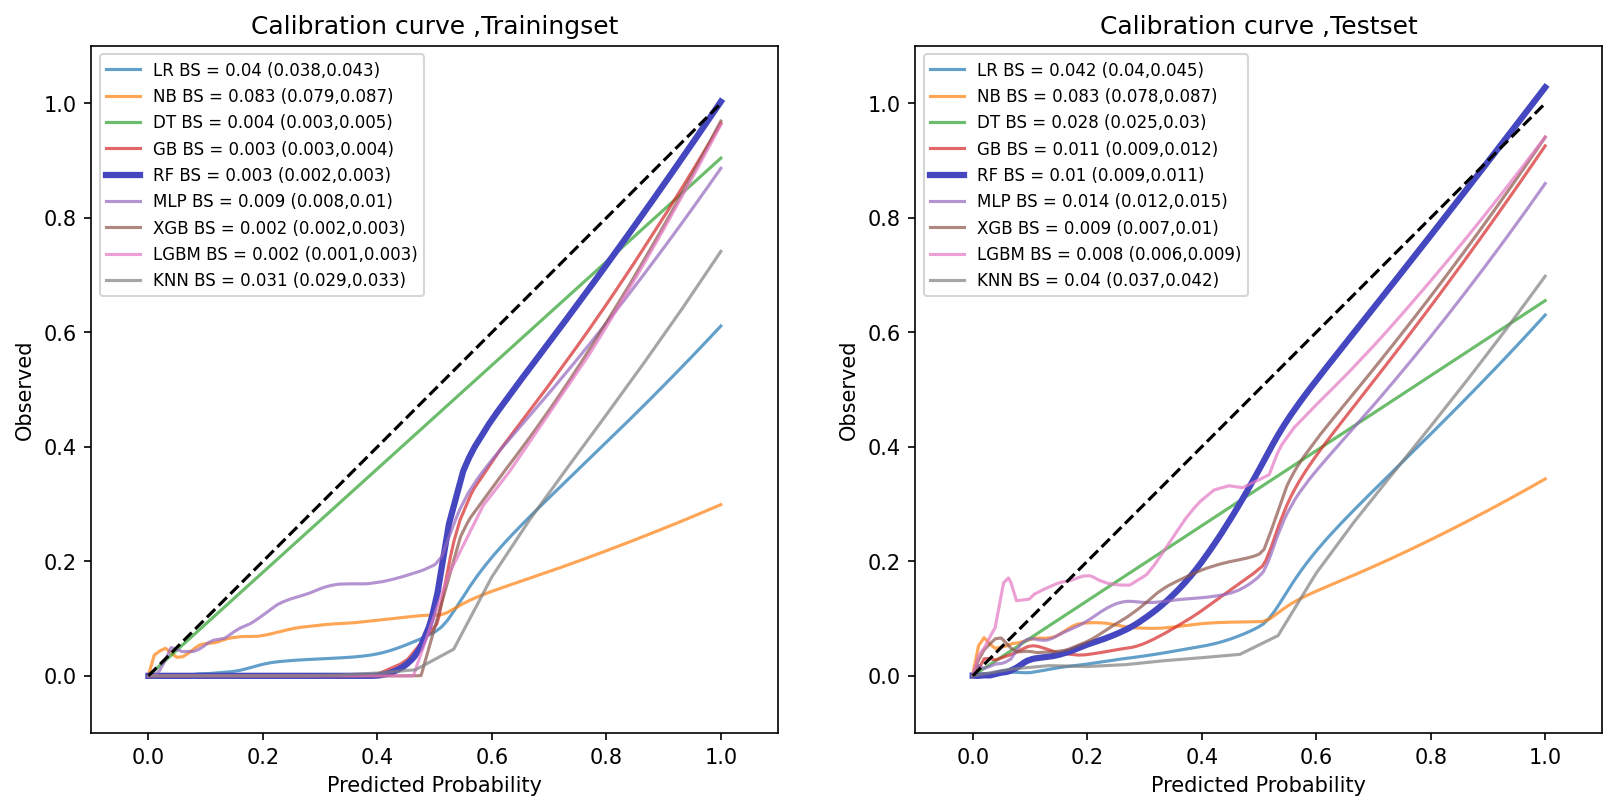

In [8]:
# 校准曲线
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import brier_score_loss#(brier_score_loss, precision_score, recall_score,f1_score)
from sklearn.calibration import calibration_curve #CalibratedClassifierCV, 
def brier_score_95CI(yy,yyP,random_state,BSCI = True):
    #https://stackoverflow.com/questions/52373318/how-to-compare-roc-auc-scores-of-different-binary-classifiers-and-assess-statist
    y_pred = np.array(yyP)#np.array(yyP.tolist())
    y_true = np.array(yy)#np.array(yy.tolist())
    n_bootstraps = 1000
    rng_seed = random_state
    bootstrapped_scores = []
    if BSCI == True:
        rng = np.random.RandomState(rng_seed)
        for i in range(n_bootstraps):
            # bootstrap by sampling with replacement on the prediction indices
            # 通过对预测指数进行替换抽样，进行引导分析
            indices = rng.randint(0, len(y_pred), len(y_pred))
            if len(np.unique(y_true[indices])) < 2:
                # We need at least one positive and one negative sample for ROC AUC
                # to be defined: reject the sample
                # 我们需要至少一个阳性样本和一个阴性样本来确定ROC AUC
                # 的定义：拒绝样本
                continue

            score = brier_score_loss(y_true[indices], y_pred[indices])#roc_auc_score(y_true[indices], y_pred[indices])
            bootstrapped_scores.append(score)

        sorted_scores = np.array(bootstrapped_scores)
        sorted_scores.sort()

        # Computing the lower and upper bound of the 90% confidence interval
        # You can change the bounds percentiles to 0.025 and 0.975 to get
        # a 95% confidence interval instead.
        confidence_lower = sorted_scores[int(0.05 * len(sorted_scores))]
        confidence_upper = sorted_scores[int(0.95 * len(sorted_scores))]
        #print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(confidence_lower, confidence_upper))
        return(brier_score_loss(y_true, y_pred),confidence_lower,confidence_upper)
    else:
        return(brier_score_loss(y_true, y_pred))
def plot_calibration_curve(clf_list,n_bins):#,fig_index):
    #fig = plt.figure(fig_index, figsize=(6, 6),dpi = 150)
    fig = plt.figure(figsize=(6, 6),dpi = 150)
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name,yy,yyP,BS,BSlower,BSupper in clf_list:        
        #clf.fit(X_train, y_train)
        #y_pred = clf.predict(X_test)
        #if hasattr(clf, "predict_proba"):
        #    prob_pos = clf.predict_proba(X_test)[:, 1]
        #else:  # use decision function
        #    prob_pos = clf.decision_function(X_test)
        #    prob_pos = \
        #        (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        prob_pos = yyP
        clf_score = round(BS,3) #= brier_score_loss(y_test, prob_pos, pos_label=y.max())
        clf_score_lower = round(BSlower,3)
        clf_score_upper = round(BSupper,3)

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(yy, yyP, n_bins=n_bins)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label = name + ' BS=' + str(round(clf_score,3)) + "(" + str(clf_score_lower) + ','+ str(clf_score_upper) + ")"
                )
                 #label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins= n_bins, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper right")#"upper center")
    plt.tight_layout()
    return(fig)

# 平滑校准曲线
def better_CCcurve(yyP,yy):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # 对P值排序并对预测值抽取序列
    p = yyP
    q = yy
    p1 = np.sort(p)
   
    # 对预测的X和Y进行lowess回归拟合
    smo = lowess(q, p, frac=2/3, it=0, delta = 0.01 * (np.max(p) - np.min(p)))

    plt.figure(figsize=(5, 5), dpi = 150)
    sns.lineplot(x=smo[:, 0], y=smo[:, 1], color='blue')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')
    plt.title('Lowess smoothing')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()
def better_CCcurve_doubleset(YYP,YY,yyP,yy,TITLE):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
    
    # 对P值排序并对预测值抽取序列
    P = YYP
    Q = YY
    P1 = np.sort(P)
    # 对预测的X和Y进行lowess回归拟合
    smo1 = lowess(Q, P, frac=2/3, it=0, delta=0.01 * (np.max(P) - np.min(P)))
    # 在ax1中绘制lowess回归拟合曲线
    ax1.plot(smo1[:, 0], smo1[:, 1], color='blue')
    ax1.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax1.set_title('Calibration curve' + TITLE + ",Traingset")
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Observed')
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylim(-0.1, 1.1)
    
    # 对P值排序并对预测值抽取序列
    p = yyp
    q = yy
    p1 = np.sort(p)
    # 对预测的X和Y进行lowess回归拟合
    smo2 = lowess(q, p, frac=2/3, it=0, delta=0.01 * (np.max(p) - np.min(p)))
    # 在ax1中绘制lowess回归拟合曲线
    ax2.plot(smo2[:, 0], smo2[:, 1], color='blue')
    ax2.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax2.set_title('Calibration curve' + TITLE + ",Testset")
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Observed')
    ax2.set_xlim(-0.1, 1.1)
    ax2.set_ylim(-0.1, 1.1)
    
    plt.show()
def better_CCcurve_doubleset_multimodel(YYPs,YY,yyPs,yy,TITLE,curve_names,BSCI = True,final_model = final_model):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6), dpi=150)
    for i in range(len(YYPs)):
        
        emphasis_color = (68/255,71/255,191/255)
        
        if BSCI == True:
            BS1,BS1lower,BS1upper = brier_score_95CI(YY,YYPs[i],random_state)
            BS2,BS2lower,BS2upper = brier_score_95CI(yy,yyPs[i],random_state)
            legendname1 = ' BS = ' + str(round(BS1,3)) + " (" + str(round(BS1lower,3)) + ','+ str(round(BS1upper,3)) + ")"
            legendname2 = ' BS = ' + str(round(BS2,3)) + " (" + str(round(BS2lower,3)) + ','+ str(round(BS2upper,3)) + ")"
        else:
            legendname1 = ', Brier score = ' + str(round(brier_score_95CI(YY,YYPs[i],random_state, BSCI = BSCI),3))
            legendname2 = ', Brier score = ' + str(round(brier_score_95CI(yy,yyPs[i],random_state, BSCI = BSCI),3))
        
        
        # 对P值排序并对预测值抽取序列
        P = YYPs[i]
        Q = YY
        P1 = np.sort(P)
        # 对预测的X和Y进行lowess回归拟合
        smo1 = lowess(Q, P, frac=2/3, it=0, delta=0.01 * (np.max(P) - np.min(P)))
        
        # 对P值排序并对预测值抽取序列
        p = yyPs[i]
        q = yy
        p1 = np.sort(p)
        # 对预测的X和Y进行lowess回归拟合
        smo2 = lowess(q, p, frac=2/3, it=0, delta=0.01 * (np.max(p) - np.min(p)))
        
        if curve_names[i] != final_model:
            # 在ax1中绘制lowess回归拟合曲线
            ax1.plot(smo1[:, 0], smo1[:, 1], label=curve_names[i] + legendname1,alpha = 0.7) # color='blue'
            # 在ax2中绘制lowess回归拟合曲线
            ax2.plot(smo2[:, 0], smo2[:, 1], label=curve_names[i] + legendname2,alpha = 0.7)# color='blue',
        if curve_names[i] == final_model:
            # 在ax1中绘制lowess回归拟合曲线
            ax1.plot(smo1[:, 0], smo1[:, 1], label=curve_names[i] + legendname1,lw = 3,color = emphasis_color) # color='blue'
            # 在ax2中绘制lowess回归拟合曲线
            ax2.plot(smo2[:, 0], smo2[:, 1], label=curve_names[i] + legendname2,lw = 3,color = emphasis_color)# color='blue',
        
    ax1.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax1.set_title('Calibration curve' + TITLE + ",Trainingset")
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Observed')
    ax1.set_xlim(-0.1, 1.1)
    ax1.set_ylim(-0.1, 1.1)
    ax1.legend(fontsize=8, loc=2)
    ax1.set_aspect('equal', adjustable='box')
    

    ax2.plot([0, 1], [0, 1], color='black', linestyle='--')
    ax2.set_title('Calibration curve' + TITLE + ",Testset")
    ax2.set_xlabel('Predicted Probability')
    ax2.set_ylabel('Observed')
    ax2.set_xlim(-0.1, 1.1)
    ax2.set_ylim(-0.1, 1.1)
    ax2.legend(fontsize=8, loc=2)
    ax2.set_aspect('equal', adjustable='box')
    
    plt.show()
def better_CCcurve_multimodel(yyPs,yy):
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import matplotlib.pyplot as plt
    import seaborn as sns
    plt.figure(figsize=(5, 5), dpi = 150)
    # 对P值排序并对预测值抽取序列
    for i in range(len(yyPs)):
        p = yyPs[i]
        # print(p)
        q = yy
        p1 = np.sort(p)
        # 对预测的X和Y进行lowess回归拟合
        smo = lowess(q, p, frac=2/3, it=0, delta = 0.01 * (np.max(p) - np.min(p)))
        sns.lineplot(x=smo[:, 0], y=smo[:, 1]) # , color='blue'
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='black') 
    plt.title('Lowess smoothing')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.show()  

better_CCcurve_doubleset_multimodel(YYPs, y_train, yyPs, y_test, TITLE  = " ", curve_names = curve_names, BSCI = True)

In [9]:
### 等渗回归
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict
# from sklearn_evaluation import plot

# def IsotonicCV(models,XX,YY):
#     models_isCVed = []
#     for i in range(len(models)):
#         clf_calib = CalibratedClassifierCV(
#             base_estimator = models[i],
#             cv=3,
#             ensemble=False,
#             method='isotonic')
#         clf_calib.fit(XX, YY)
#         models_isCVed.append(clf_calib)
#     return(models_isCVed)

def IsotonicCV(models, XX, YY):
    models_isCVed = []
    for i in range(len(models)):
        # 假设模型是LogisticRegression，你可以在这里增加max_iter
        if isinstance(models[i], LogisticRegression):
            models[i].set_params(max_iter=1000)
        
        clf_calib = CalibratedClassifierCV(
            base_estimator=models[i],
            cv=3,
            ensemble=False,
            method='isotonic')
        clf_calib.fit(XX, YY)
        models_isCVed.append(clf_calib)
    return models_isCVed

models_for_isCV = best_models# [best_models[i][0] for i in range(len(best_models))]
models_isCVed = IsotonicCV(models_for_isCV,X_train,y_train)

C:\Users\Administrator\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Administrator\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

[LightGBM] [Info] Number of positive: 290, number of negative: 6862
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3300
[LightGBM] [Info] Number of data points in the train set: 7152, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.040548 -> initscore=-3.163873
[LightGBM] [Info] Start training from score -3.163873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

c:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\Administrator\anaconda3\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


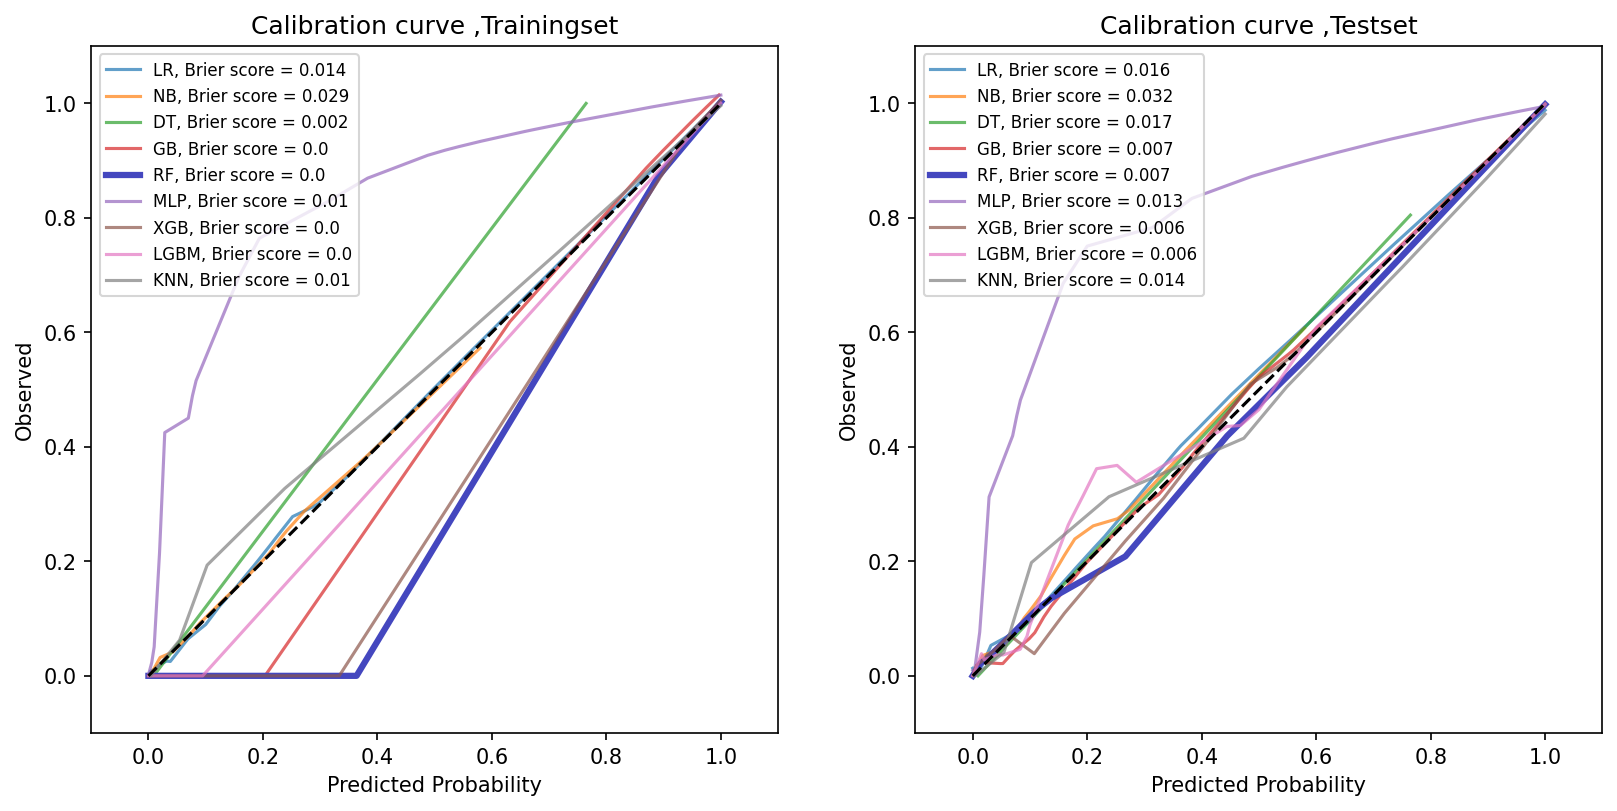

In [10]:
YYPs_isCVed = [models_isCVed[i].predict_proba(X = X_train)[:,1] for i in range(len(models_isCVed))]
yyPs_isCVed = [models_isCVed[i].predict_proba(X = X_test)[:,1] for i in range(len(models_isCVed))]
better_CCcurve_doubleset_multimodel(YYPs_isCVed, y_train, yyPs_isCVed, y_test, TITLE  = " ", curve_names = curve_names, BSCI = False, final_model = final_model)

## DCA

0.030852847611166186
0.037062140510416376


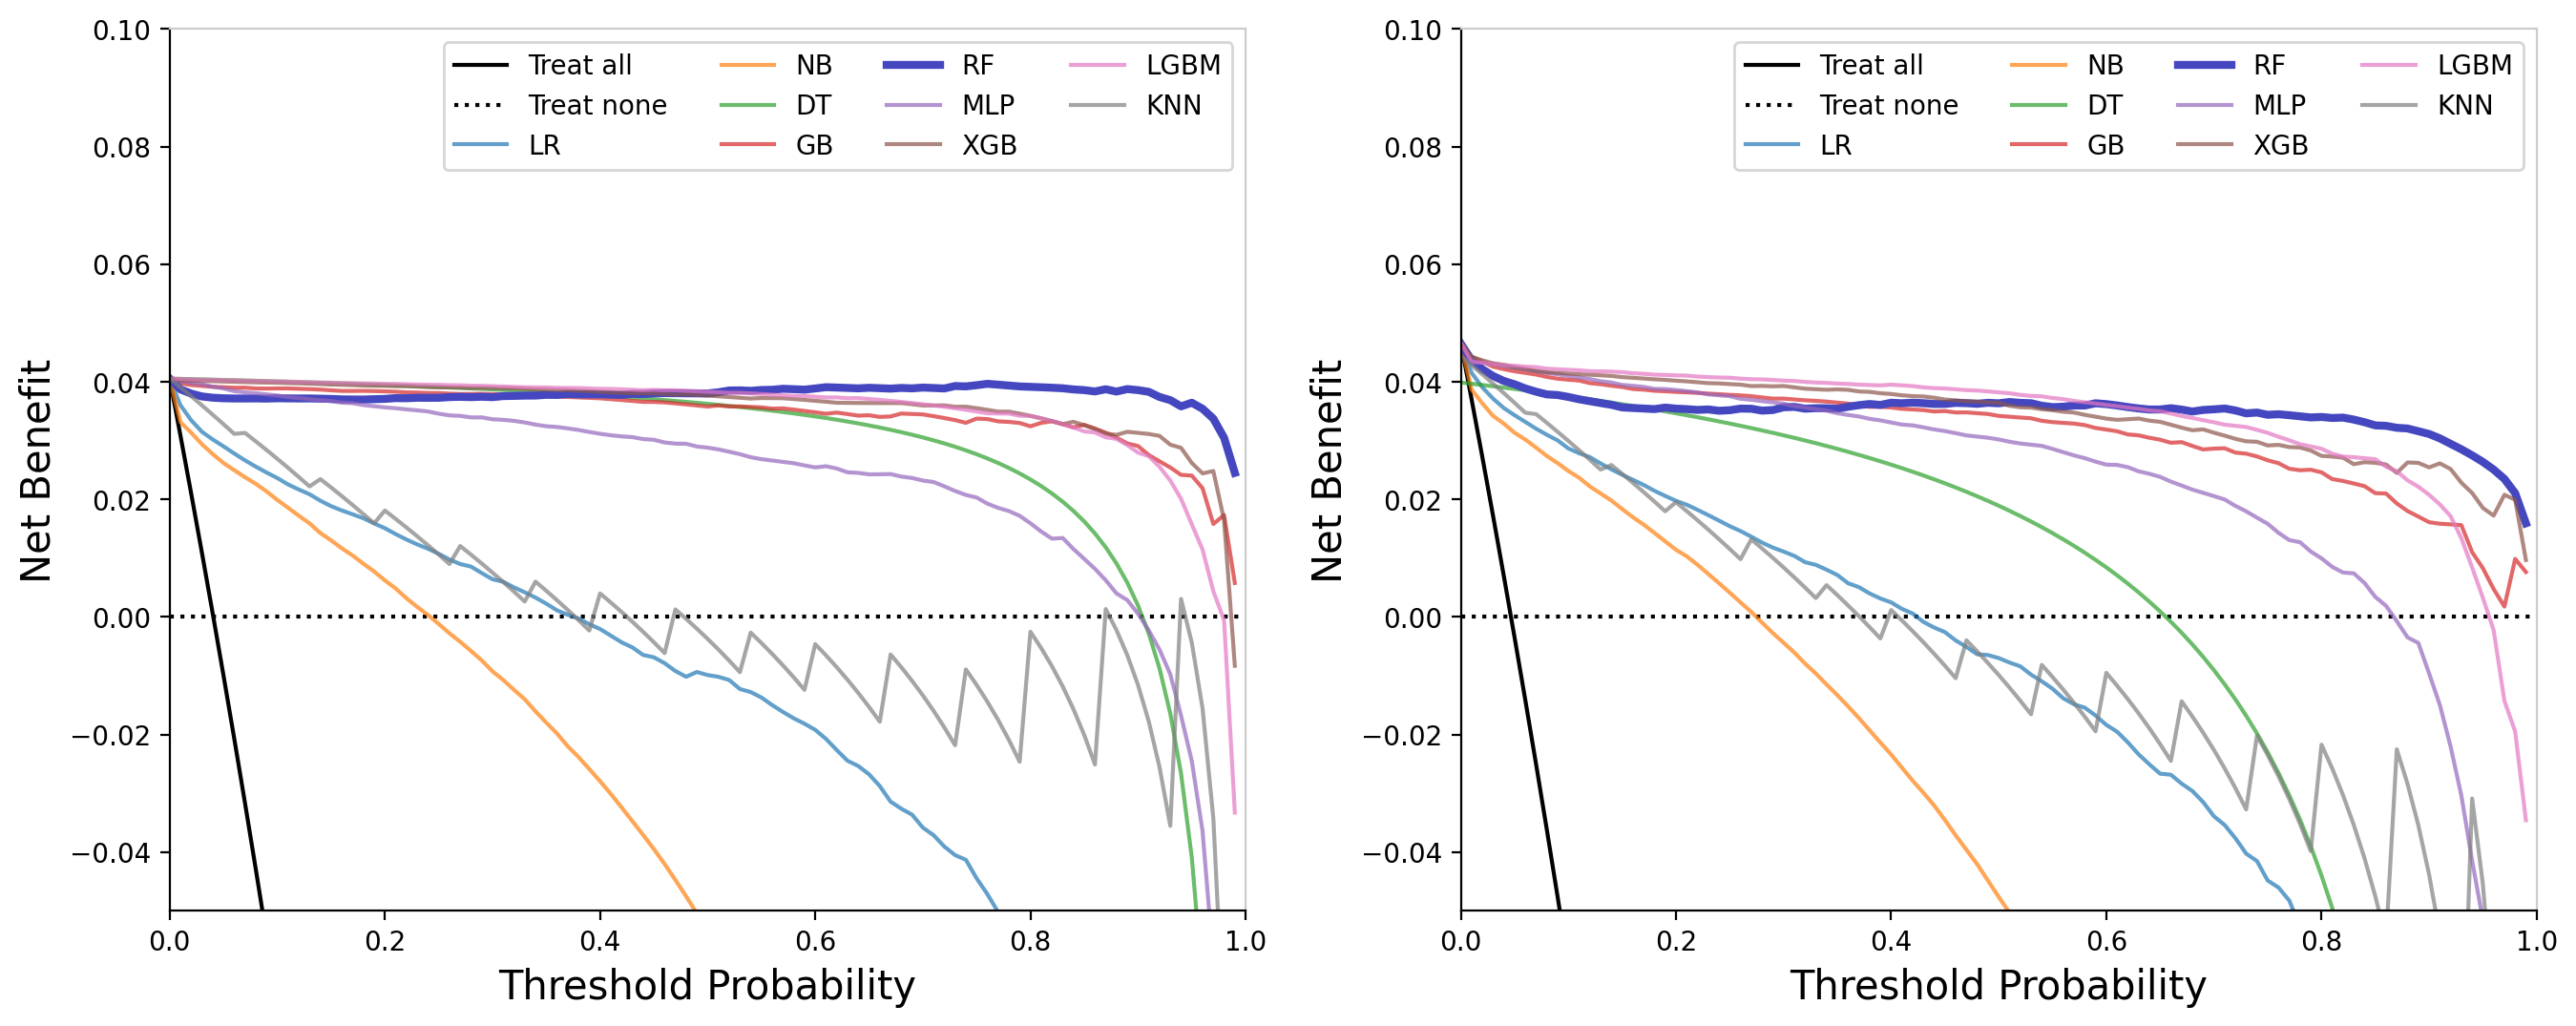

In [11]:
## 决策曲线
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def calculate_net_benefit_model(thresh_group, y_pred_score, y_label):
    net_benefit_model = np.array([])
    for thresh in thresh_group:
        y_pred_label = y_pred_score > thresh
        tn, fp, fn, tp = confusion_matrix(y_label, y_pred_label).ravel()
        n = len(y_label)
        net_benefit = (tp / n) - (fp / n) * (thresh / (1 - thresh))
        net_benefit_model = np.append(net_benefit_model, net_benefit)
    return net_benefit_model
def calculate_net_benefit_all(thresh_group, y_label):
    net_benefit_all = np.array([])
    tn, fp, fn, tp = confusion_matrix(y_label, y_label).ravel()
    total = tp + tn
    for thresh in thresh_group:
        net_benefit = (tp / total) - (tn / total) * (thresh / (1 - thresh))
        net_benefit_all = np.append(net_benefit_all, net_benefit)
    return net_benefit_all
def plot_DCAs(YYPs, YY, yyPs, yy, curve_names, plot_alphas,ylim,final_model = final_model):
    emphasis_color = (68/255,71/255,191/255)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,6),dpi = 200)
    thresh_group = np.arange(0,1,0.01)
    # print(YY)
    # print(yy)
    ########################训练集#######################
    Train_net_benefit_all = calculate_net_benefit_all(thresh_group, YY)
    print(Train_net_benefit_all[1])
    ax1.plot(thresh_group, Train_net_benefit_all, color = 'black',label = 'Treat all')
    ax1.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')
    for i in range(len(YYPs)):
        Train_net_benefit_model = calculate_net_benefit_model(thresh_group, YYPs[i], YY)
        if curve_names[i] != final_model:
            ax1.plot(thresh_group, Train_net_benefit_model, label = curve_names[i],alpha = 0.7) # alpha = plot_alphas[i],
        if curve_names[i] == final_model:
            ax1.plot(thresh_group, Train_net_benefit_model, label = curve_names[i],lw = 3,color = emphasis_color) # alpha = plot_alphas[i],


    ax1.set_xlim(0,1)
    ax1.set_ylim(ylim[0],ylim[1])
    ax1.set_xlabel(
        xlabel = 'Threshold Probability',fontsize=15
        # fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax1.set_ylabel(
        ylabel = 'Net Benefit', fontsize=15
        # fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax1.grid('major')
    ax1.spines['right'].set_color((0.8, 0.8, 0.8))
    ax1.spines['top'].set_color((0.8, 0.8, 0.8))
    ax1.legend(loc = 'best',ncol = 4)
    ax1.grid(False)
    
    ########################测试集#######################
    Test_net_benefit_all = calculate_net_benefit_all(thresh_group, yy)
    print(Test_net_benefit_all[1])
    ax2.plot(thresh_group, Test_net_benefit_all, color = 'black',label = 'Treat all')
    ax2.plot((0, 1), (0, 0), color = 'black', linestyle = ':', label = 'Treat none')
    for i in range(len(yyPs)):
        Test_net_benefit_model = calculate_net_benefit_model(thresh_group, yyPs[i], yy)
        if curve_names[i] != final_model:
            ax2.plot(thresh_group, Test_net_benefit_model, label = curve_names[i],alpha = 0.7) # alpha = plot_alphas[i],
        if curve_names[i] == final_model:
            ax2.plot(thresh_group, Test_net_benefit_model, label = curve_names[i],lw = 3,color = emphasis_color) # alpha = plot_alphas[i],
        
    ax2.set_xlim(0,1)
    # ax2.set_ylim(Test_net_benefit_model.min() - 0.01, Test_net_benefit_model.max() + 0.01)#adjustify the y axis limitation
    ax2.set_ylim(ylim[0],ylim[1])
    ax2.set_xlabel(
        xlabel = 'Threshold Probability', fontsize=15
        #fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax2.set_ylabel(
        ylabel = 'Net Benefit', fontsize=15
        #fontdict= {'family': 'Times New Roman', 'fontsize': 15}
        )
    ax2.grid('major')
    ax2.spines['right'].set_color((0.8, 0.8, 0.8))
    ax2.spines['top'].set_color((0.8, 0.8, 0.8))
    ax2.legend(loc = 'best',ncol = 4)
    ax2.grid(False)
    plt.show()


plot_alphas = [1]*20# [0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,1]

plot_DCAs(YYPs, y_train, yyPs, y_test, curve_names,plot_alphas,ylim = (-0.05,0.1),final_model = final_model)

## SHAP

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


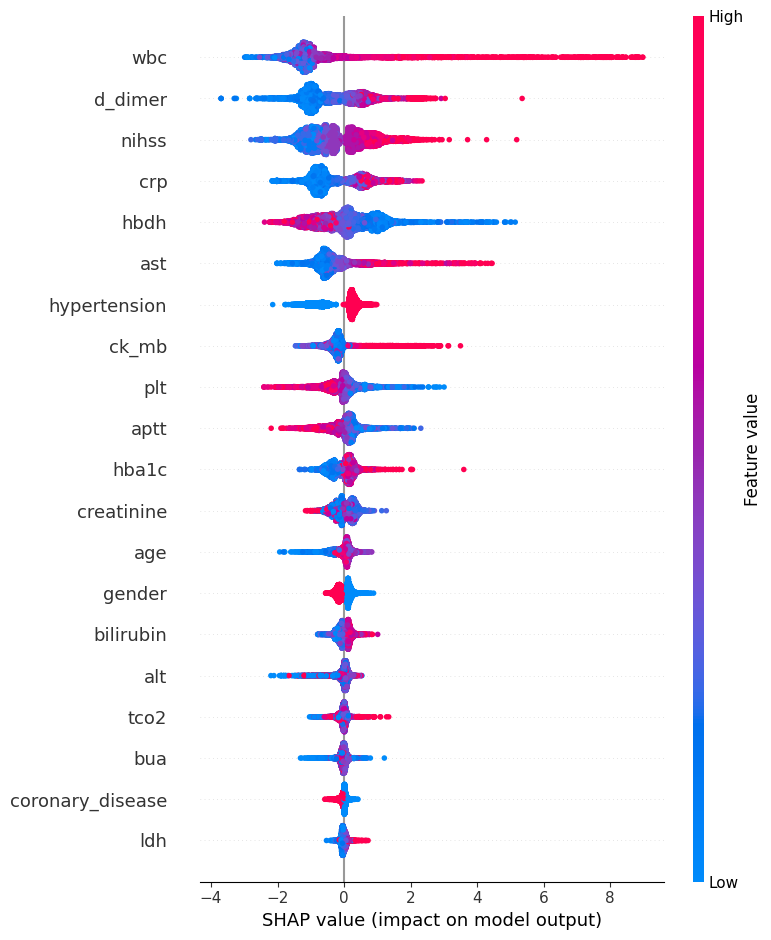

In [56]:
import joblib
import shap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# Split the data into features and target variable
X = X_train[selected_features] 
y = data[var]
# 读取随机森林模型
model_name='LightGBM_model'#random_forest_model LightGBM_model  XGBoost_model
model = joblib.load('H:\\model\\{}\\{}.pkl'.format(var,model_name))

# 初始化SHAP解释器并计算SHAP值
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X)
shap_values = explainer.shap_values(X)
joblib.dump(shap_values, 'H:\\shap\\{}\\{}_shap_values.pkl'.format(var,model_name))

shap.summary_plot(shap_values[1],X,max_display=75)
plt.show()




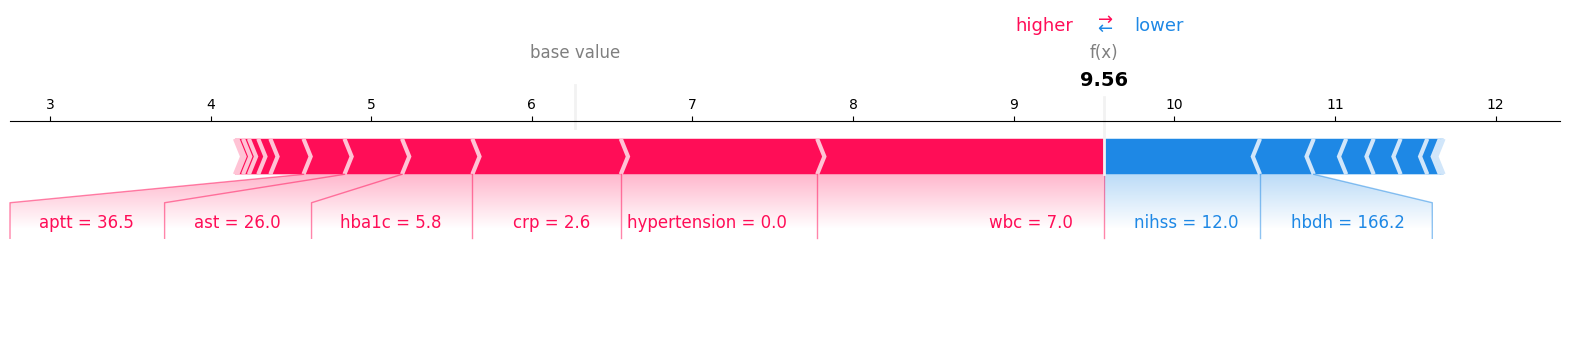

In [51]:
# 我们将检查测试集中的第一个样本，以确定哪些特征导致了“0”结果。为此，我们将利用力图并提供预期值、形状值和测试样本。
shap.plots.force(explainer.expected_value[0], shap_values[0][0,:], X.iloc[0, :], matplotlib = True)

### decision_plot

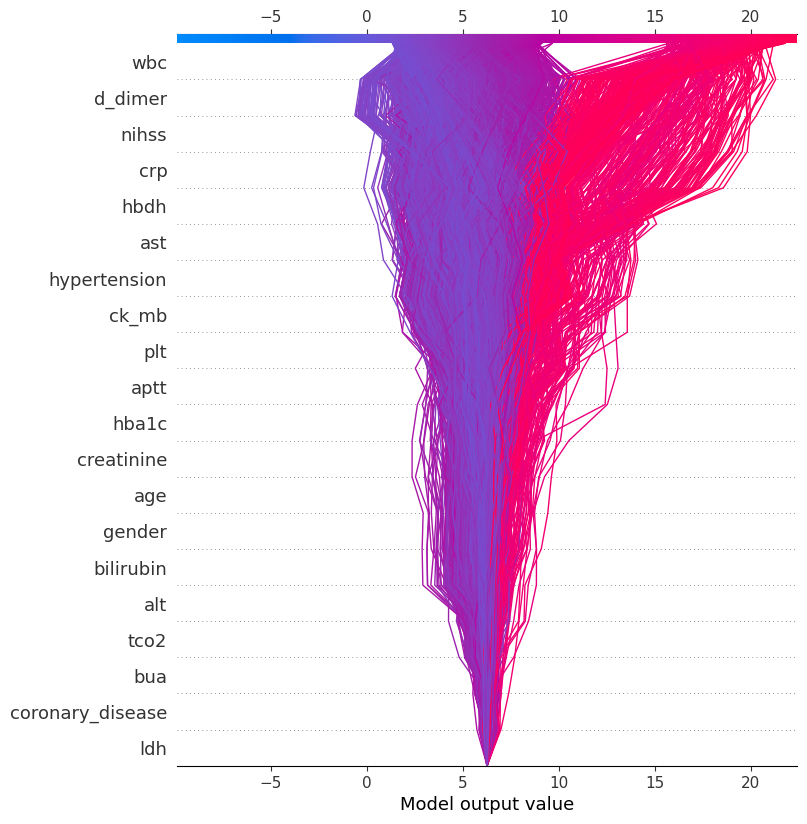

In [52]:
# 我们现在将显示decision_plot. 它通过映射每个预测的累积 SHA 值来直观地描述模型决策。
shap.decision_plot(explainer.expected_value[0], shap_values[1], X.columns,ignore_warnings=True)

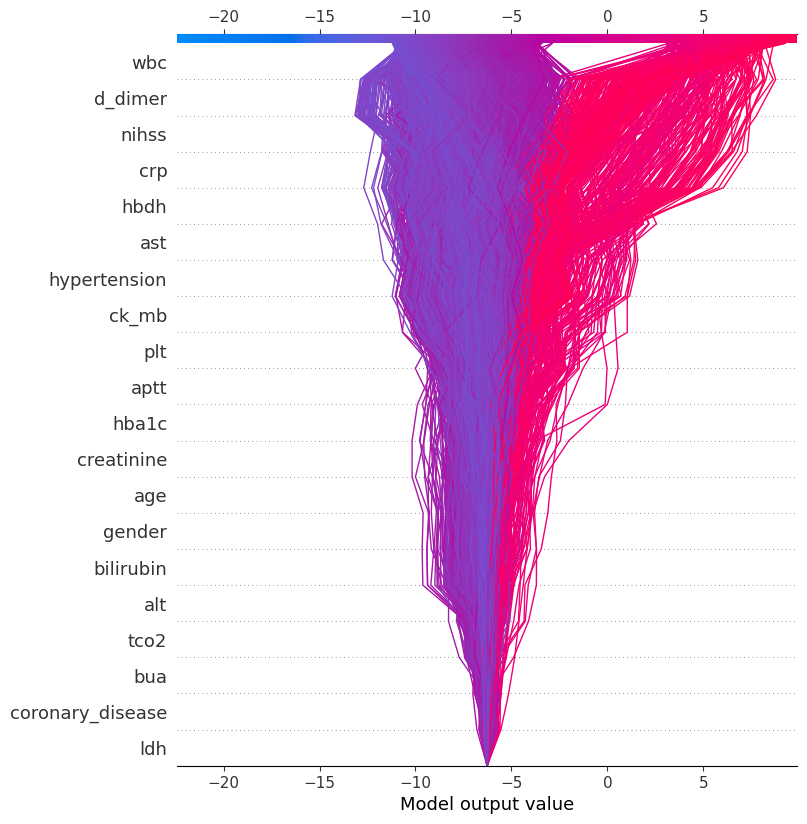

In [57]:
shap.decision_plot(explainer.expected_value[1], shap_values[1], X.columns,ignore_warnings=True)